In [1]:
import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Skeleton topology
topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]

In [3]:
skeletons_A_1 = blazepose_skeletons('1681479402_cam0.avi')
skeletons_A_2 = blazepose_skeletons('1681479402_cam1.avi')
skeletons_B_1 = blazepose_skeletons('1681479402_cam2.avi')
skeletons_B_2 = blazepose_skeletons('1681479402_cam3.avi')

In [10]:
rota_skeletons_A_1 = skeletons_A_1.clone()
rota_skeletons_A_2 = skeletons_A_2.clone()
rota_skeletons_B_1 = skeletons_B_1.clone()
rota_skeletons_B_2 = skeletons_B_2.clone()

rota_skeletons_A_1[:, :, 2] = -skeletons_A_1[:, :, 1]
rota_skeletons_A_1[:, :, 1] = skeletons_A_1[:, :, 2]
rota_skeletons_A_2[:, :, 2] = -skeletons_A_2[:, :, 1]
rota_skeletons_A_2[:, :, 1] = skeletons_A_2[:, :, 2]
rota_skeletons_B_1[:, :, 2] = -skeletons_B_1[:, :, 1]
rota_skeletons_B_1[:, :, 1] = skeletons_B_1[:, :, 2]
rota_skeletons_B_2[:, :, 2] = -skeletons_B_2[:, :, 1]
rota_skeletons_B_2[:, :, 1] = skeletons_B_2[:, :, 2]

In [11]:
center_A_1 = rota_skeletons_A_1[:, 0].unsqueeze(1).repeat(1, len(topology), 1)
center_A_2 = rota_skeletons_A_2[:, 0].unsqueeze(1).repeat(1, len(topology), 1)
center_B_1 = rota_skeletons_B_1[:, 0].unsqueeze(1).repeat(1, len(topology), 1)
center_B_2 = rota_skeletons_B_2[:, 0].unsqueeze(1).repeat(1, len(topology), 1)

rota_skeletons_A_1 = rota_skeletons_A_1 - center_A_1
rota_skeletons_A_2 = rota_skeletons_A_2 - center_A_2
rota_skeletons_B_1 = rota_skeletons_B_1 - center_B_1
rota_skeletons_B_2 = rota_skeletons_B_2 - center_B_2

In [15]:
alpha = 2 * np.arctan(1.5 / 3.)
depth_confidence = 0.0

skeletons_A = extract_skeletons(rota_skeletons_A_1, rota_skeletons_A_2, alpha=alpha, depth_confidence=depth_confidence)
skeletons_B = extract_skeletons(rota_skeletons_B_1, rota_skeletons_B_2, alpha=alpha, depth_confidence=depth_confidence)

In [16]:
def change_frame(skeletons_1, skeletons_2, skeletons_merged_1, frame_name, alpha, topology):

    if frame_name == 'general':
        angles = [alpha/2, -alpha/2, alpha/2]
    if frame_name == 1:
        angles = [0, -alpha, 0]
    if frame_name == 2:
        angles = [alpha, 0, alpha]
    
    batch_size, n_joints, _ = skeletons_A.shape
    
    outputs = []
    
    for i, skeleton in enumerate([skeletons_1, skeletons_2, skeletons_merged_1]):

        # Measure skeleton bone lengths
        lengths = torch.Tensor(batch_size, n_joints)
        for child, parent in enumerate(topology):
            lengths[:, child] = torch.sqrt(
                torch.sum(
                    (skeleton[:, child] - skeleton[:, parent])**2,
                    axis=-1
                )
            )

        # Find the corresponding angles
        offsets = torch.zeros(batch_size, n_joints, 3)
        offsets[:, :, -1] = lengths
        quaternions = find_quaternions(topology, offsets, skeleton)
        
        # Rotate of alpha
        alpha = angles[i]
        rotation = torch.Tensor([np.cos(alpha/2), 0, 0, np.sin(alpha/2)]).unsqueeze(0).repeat(batch_size*n_joints, 1)
        quaternions = quaternions.reshape(batch_size*n_joints, 4)
        quaternions = batch_quat_left_multiply(
            batch_quat_inverse(rotation),
            quaternions
        )
        quaternions = quaternions.reshape(batch_size, n_joints, 4)

        # Use these quaternions in the forward kinematics with the Poppy skeleton
        skeleton = forward_kinematics(
            topology,
            torch.zeros(batch_size, 3),
            offsets,
            quaternions
        )[0]
        
        outputs.append(skeleton.clone())
        
    return outputs

In [21]:
skel_A_1, skel_A_2, skel_A = change_frame(rota_skeletons_A_1, rota_skeletons_A_2, skeletons_A, 'general', alpha, topology)
skel_B_1, skel_B_2, skel_B = change_frame(rota_skeletons_B_1, rota_skeletons_B_2, skeletons_B, 'general', alpha, topology)

<IPython.core.display.Javascript object>


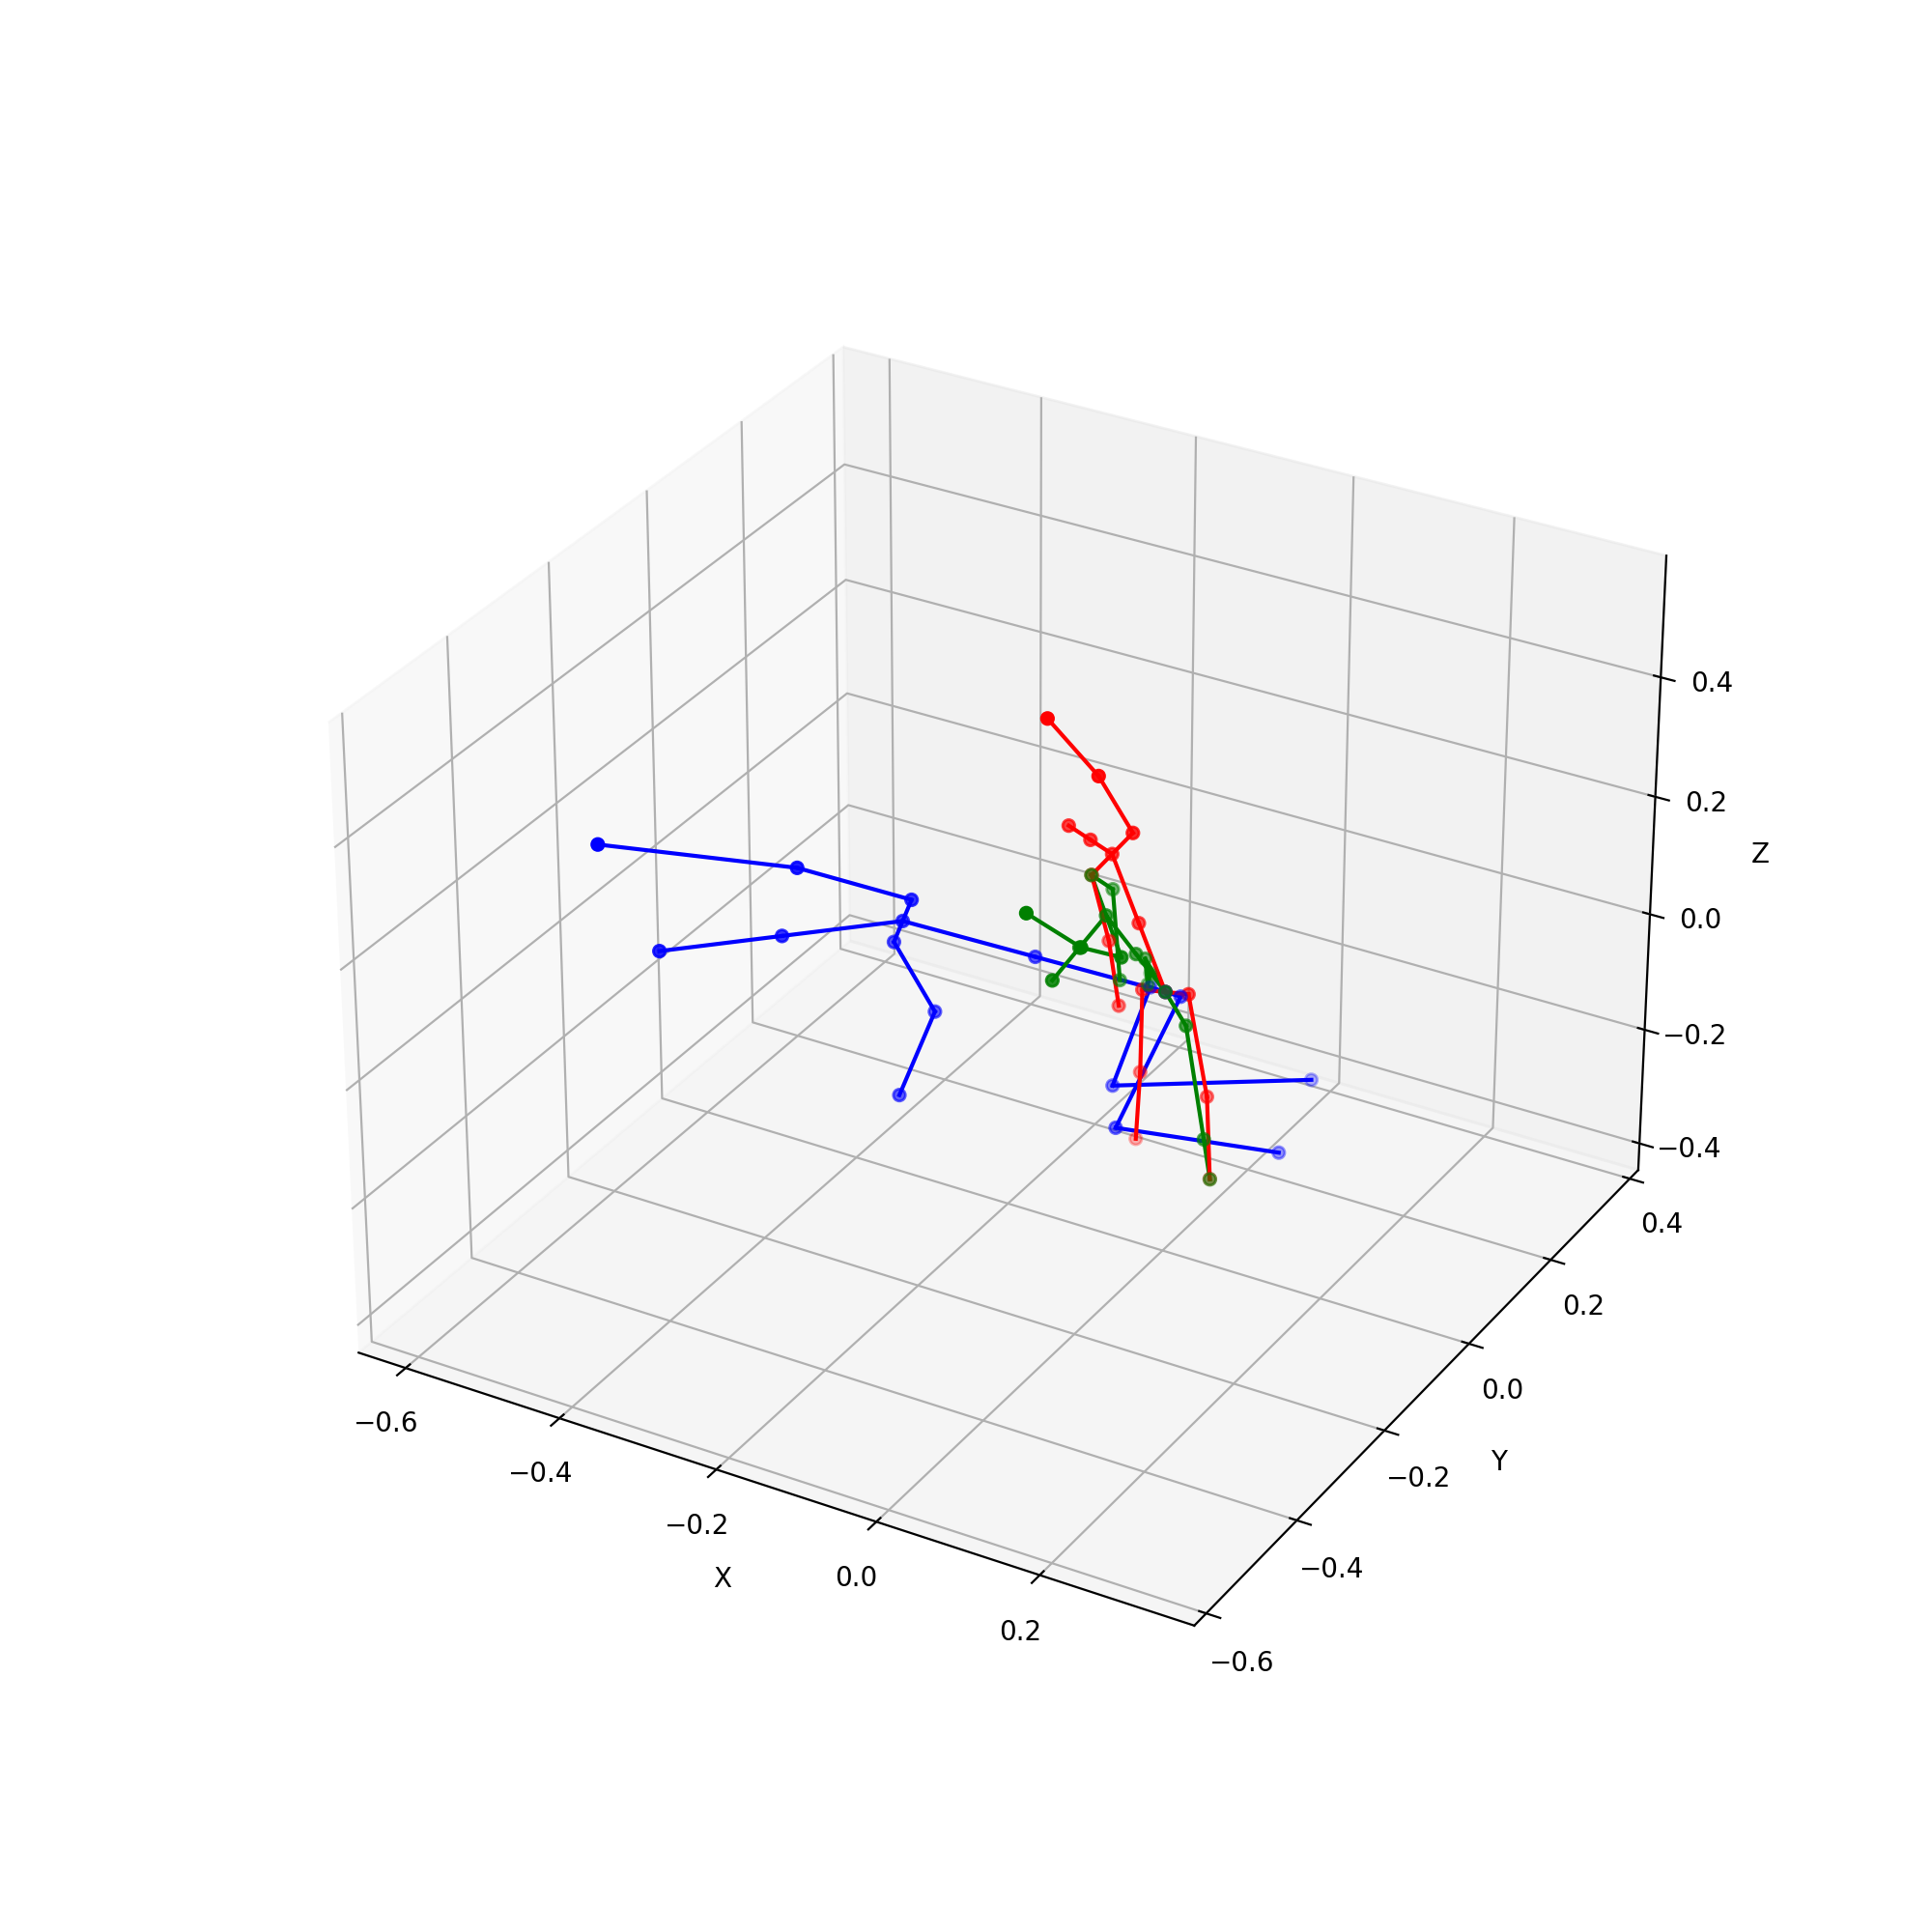

In [26]:
%matplotlib notebook

t = np.random.randint(skeletons_A.shape[0])

ax = pyplot_skeleton(topology, skel_A_1[t], show=False, color='blue')
pyplot_skeleton(topology, skel_A_2[t], ax=ax, show=False, color='green')
pyplot_skeleton(topology, skel_A[t], ax=ax, show=True, color='red')

<IPython.core.display.Javascript object>


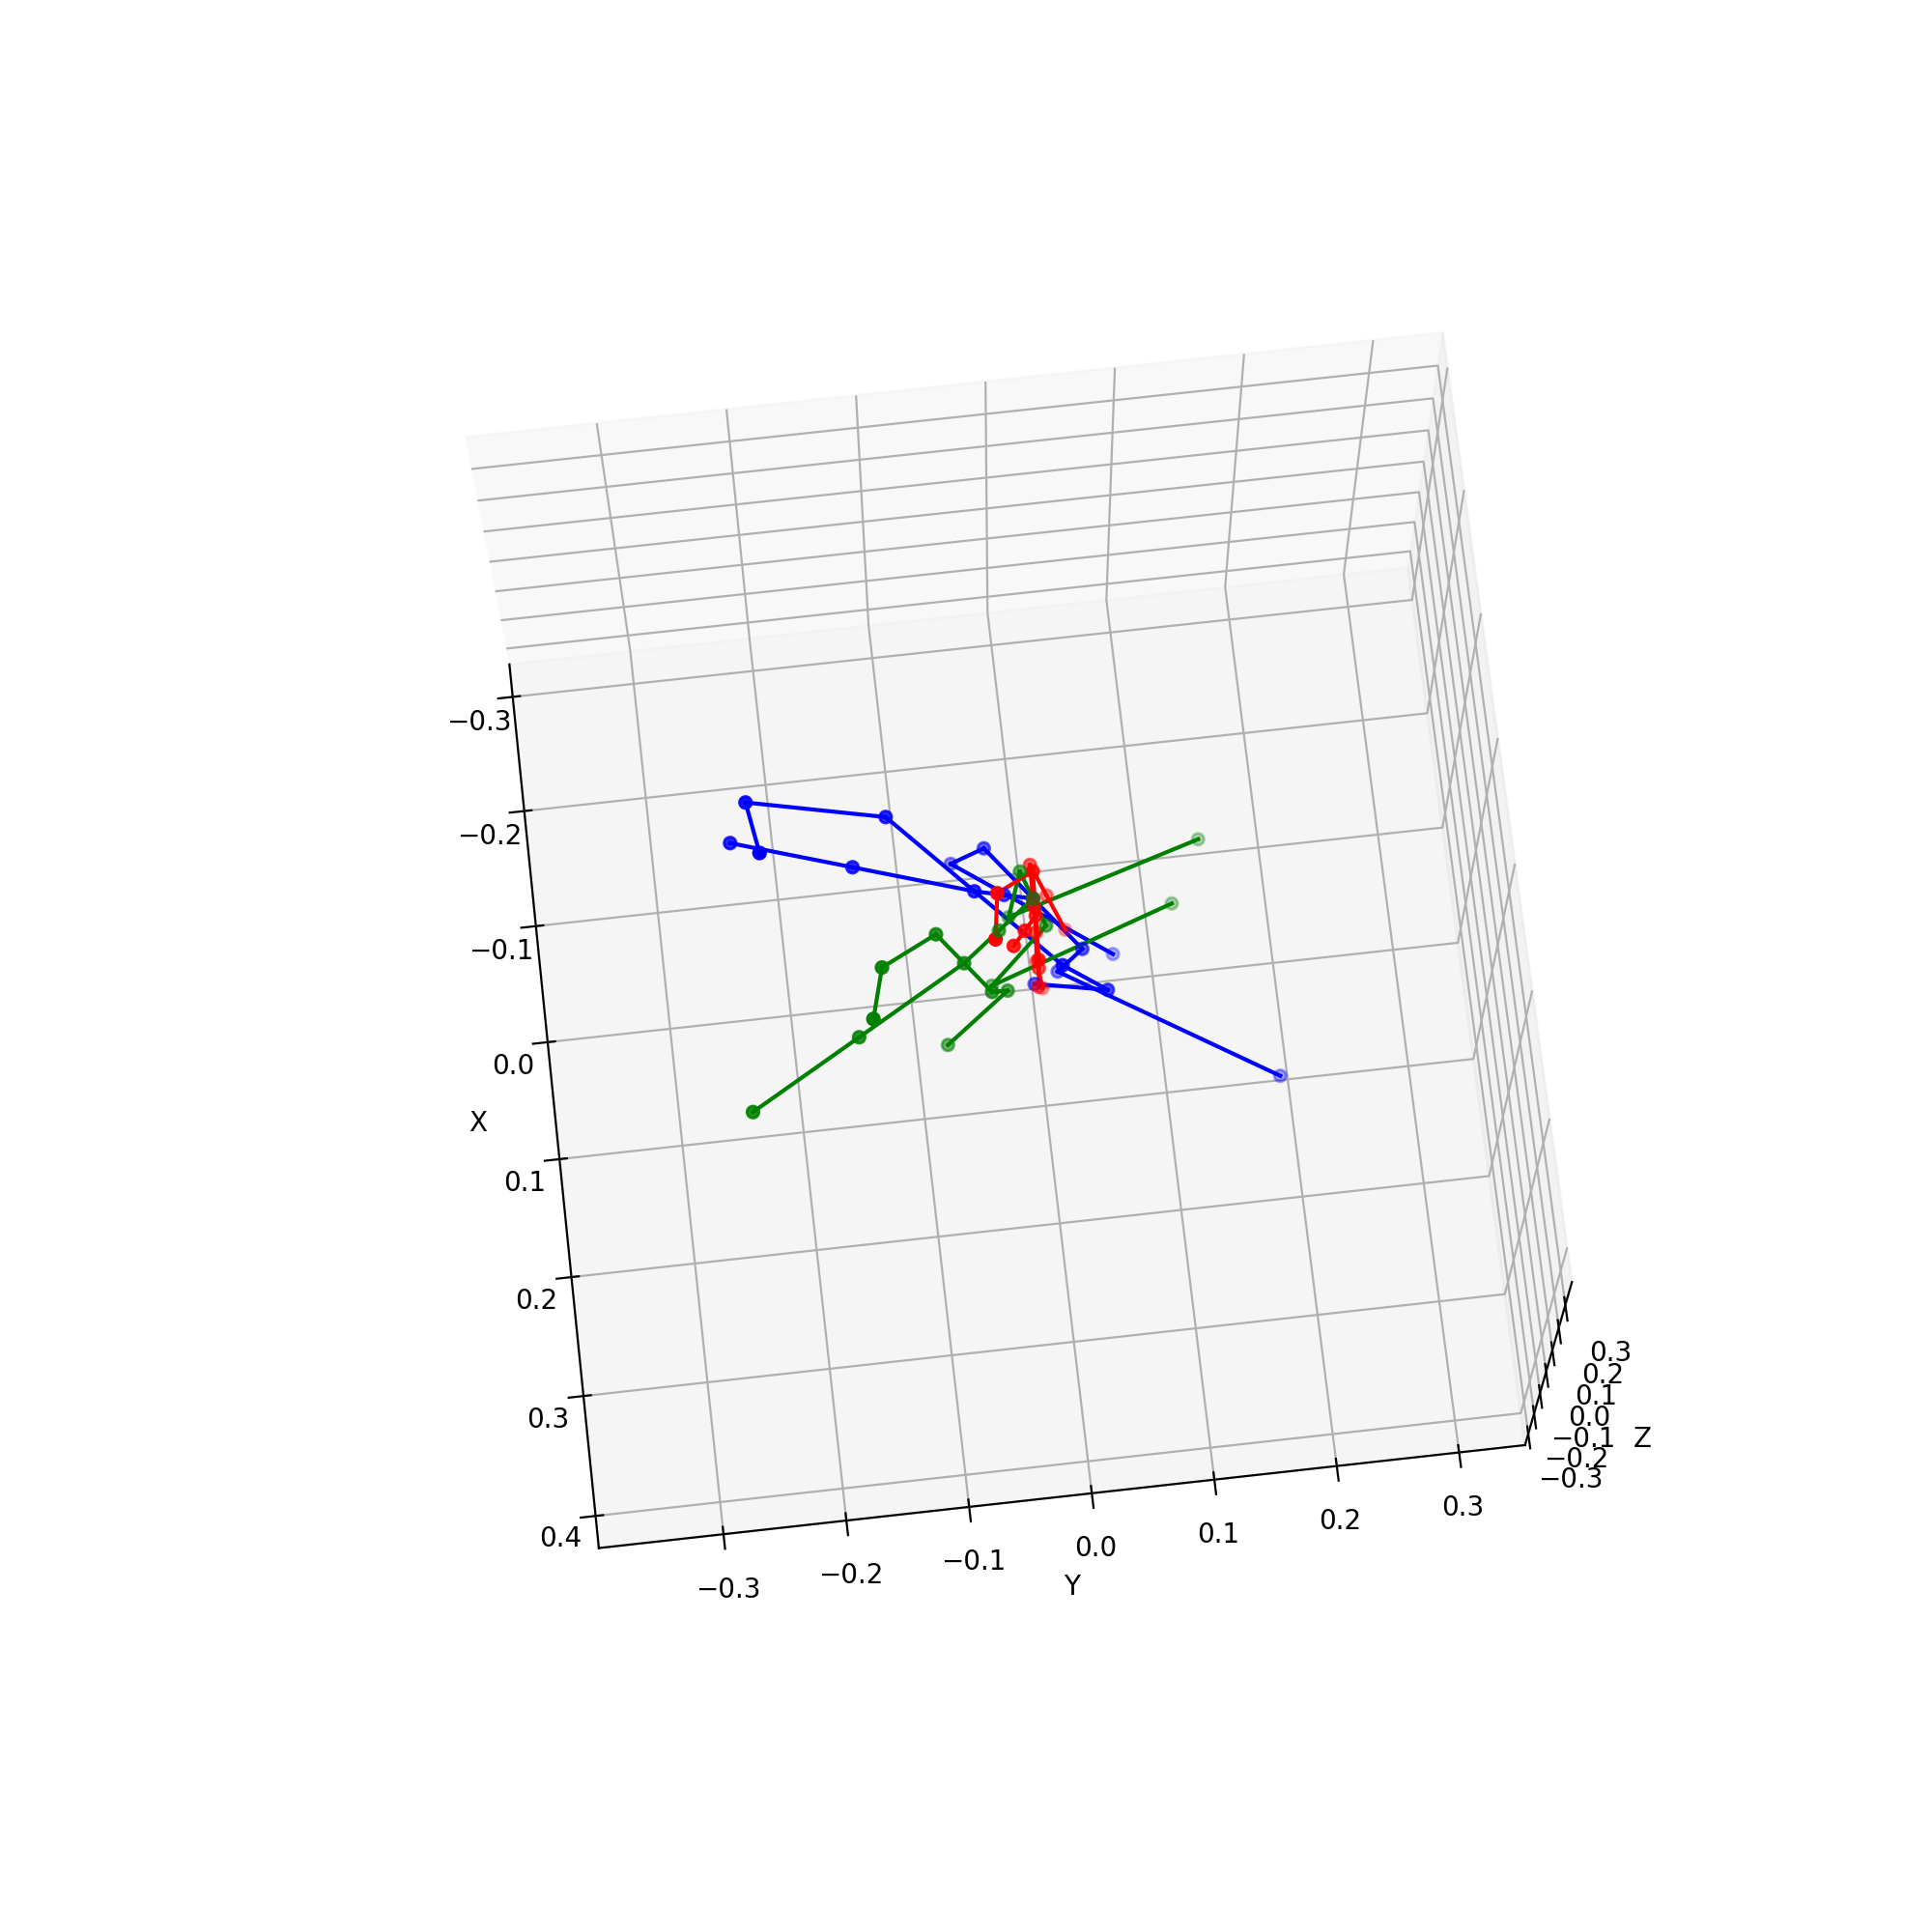

In [49]:
%matplotlib notebook

ax = pyplot_skeleton(topology, skel_B_1[t], show=False, color='blue')
pyplot_skeleton(topology, skel_B_2[t], ax=ax, show=False, color='green')
pyplot_skeleton(topology, skel_B[t], ax=ax, show=True, color='red')

<IPython.core.display.Javascript object>


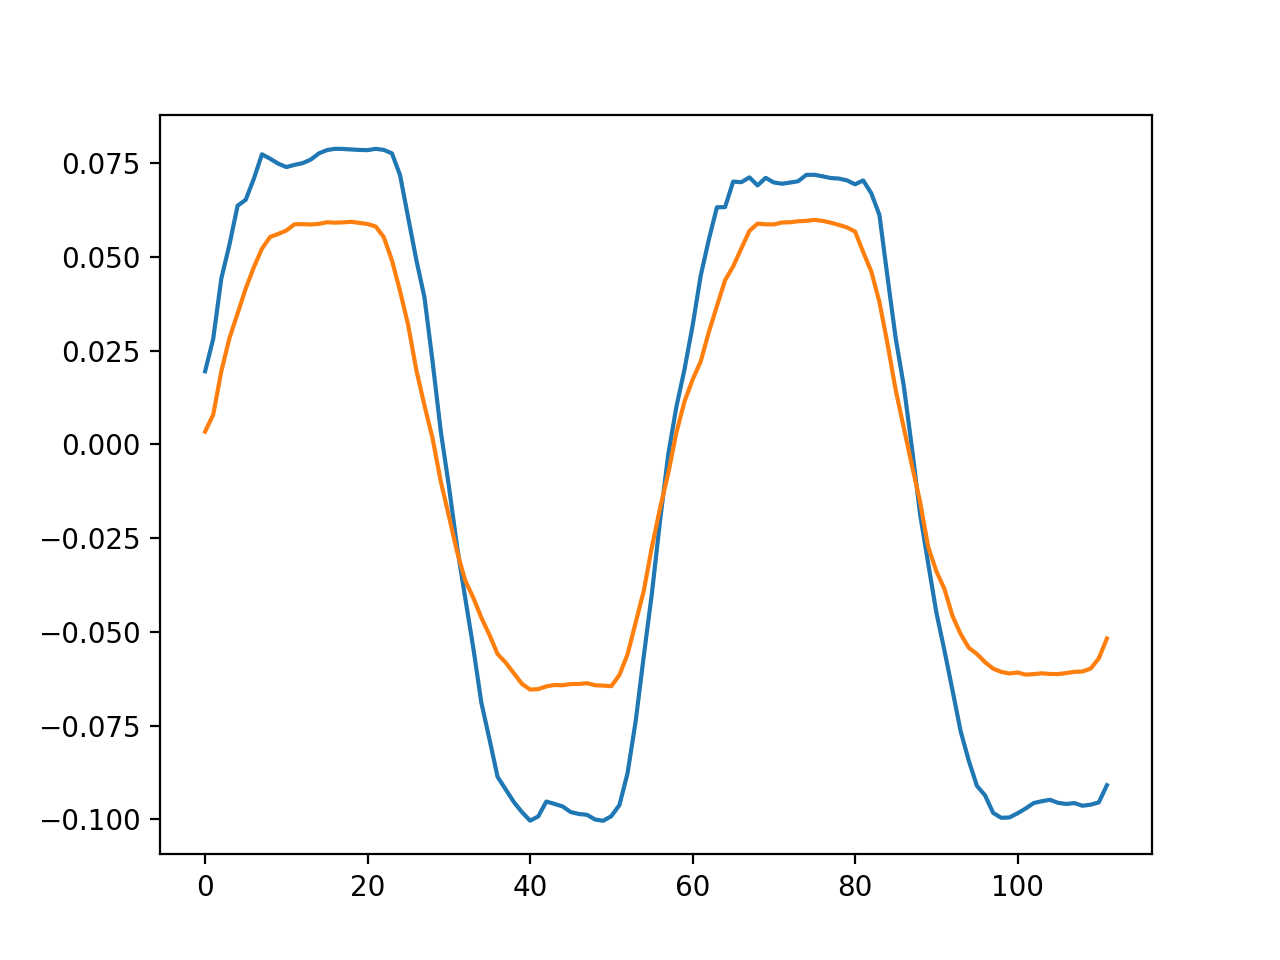

In [52]:
%matplotlib notebook

plt.plot(skel_A[:, 9, 0])
plt.plot(skel_B[:, 9, 0])
plt.show()

In [50]:
skel_B[:, :, 0] *= -1